In [1]:
import os 
import pandas as pd
import numpy as np
import pickle

from scipy.stats import kstest
from scipy.stats import f_oneway 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error as MAE

from xgboost import XGBRegressor as XGB
from lightgbm import LGBMRegressor as LGB

from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = (15,5)

In [ ]:
# data loding
# 서울시, 부산 2016 ~ 2017 실거래 데이터
df = pd.read_csv("sampled_train.csv") 

# merge를 위한 참조 데이터 
ref_df = pd.read_excel("한국행정구역분류.xlsx", sheet_name = '법정동코드 연계 자료분석용',
                       header = 1)

# 구별 특성 데이터 
park_df = pd.read_csv("park.csv") #encoding = 'utf-8')
day_care_center_df = pd.read_csv("day_care_center.csv")

#### ref_df 전처리

In [ ]:
#transaction_real_price -> Y 로 변경
df.rename({'transaction_real_price' : 'Y'},axis = 1, inplace = True)

#df 불필요 변수 제거
df.drop(['transaction_id', 'addr_kr'], axis = 1, inplace = True)

#ref_df 필요변수 선택 및 변수명 df 와 일치 
ref_df = ref_df[['시도','시군구','법정동']]
ref_df.rename({'시도' : 'city',
               '시군구' : 'gu',
               '법정동' : 'dong'}, axis = 1 , inplace = True)
ref_df = ref_df.loc[ref_df['city'].isin(['서울특별시', '부산광역시'])]

#df 시-동 중 ref_df 에 없는 데이터 - 부산 정관읍 용수리
#city_dong_unique.loc[~np.isin(city_dong_unique['dong'], ref_df['dong'])]

#ref_df 에는 정관읍, 용수리 둘다 있음
#ref_df.loc[ref_df['dong'] == '정관읍']

#df에 정관읍, 용수리로 되어있는 data는 없음
#df.loc[df['dong'] == '용수리']

#따라서 정관읍 용수리 -> 정관읍으로 변경
df.loc[df['dong'] == '정관읍 용수리','dong'] = '정관읍'

#df 시-동 unique - 61가지
city_dong_unique = df.drop_duplicates(['city', 'dong'])[['city','dong']]
#city_dong_unique 에 gu 부착
city_dong_unique = city_dong_unique.merge(ref_df, how = 'left', on = ['city', 'dong']).drop_duplicates(['dong'])

In [144]:
# 구변수 부착
df = df.merge(city_dong_unique, how = 'left',on = ['city','dong'])

# transaction_year_month 로 year, month 데이터 생성
df['year'] = pd.to_datetime(df['transaction_year_month'], format = "%Y%m").dt.year
df['month'] = pd.to_datetime(df['transaction_year_month'], format = "%Y%m").dt.month
df.drop(['transaction_year_month'], axis = 1, inplace = True)

# year of completion 으로 아파트별 age 변수 생성
df['age'] = df['year'] - df['year_of_completion']

# floor 평균 가격에 근거하여 floor level 변수 생성 - 아래 시각화 참조
def floor_level(x):
    if x < 26 :
        return 'low'
    elif x < 52 :
        return 'middle'
    elif x < 72 :
        return 'high'
    else :
        return 'very high'
    
df['floor_level'] = df['floor'].apply(floor_level)

In [ ]:
#시세 변수 추가

#구별 전체 평균 시세
mean_price_per_gu = df.groupby(['city','gu'], as_index = False)['Y'].mean()
mean_price_per_gu.sort_values(by = 'Y', inplace =True)
mean_price_per_gu.rename({'Y' : '구별_평균_시세'}, axis = 1, inplace = True)
df = df.merge(mean_price_per_gu, how = 'left', on = ['city','gu'])

#구별 가격 차이 범주 - 아래 시각화 bar plot 참조
def gu_price_level(x):
    if x <= 49633 :
        return 'cheap'
    elif x < 90000 :
        return 'resonable'
    else :
        return 'expensive'
price_level_gu = mean_price_per_gu.copy()
price_level_gu['price_level_gu'] = price_level_gu['구별_평균_시세'].apply(gu_price_level)
price_level_gu.drop('구별_평균_시세',axis = 1, inplace = True)
df = df.merge(price_level_gu, how = 'left', on = ['city', 'gu'])

#구별 작년 평균 시세, 구별 작년 거래량 변수
mean_price_per_gu_year = df.groupby(['city','gu','year'], as_index = False)['Y'].agg(['mean','count']).reset_index()
mean_price_per_gu_year['year'] = mean_price_per_gu_year['year'] + 1 # year 통해 merge 2016을 2017
mean_price_per_gu_year.rename({'mean' : "구별_작년_평균_시세",
                               'count': '구별_작년_거래량'}, axis = 1, inplace = True)

#구별 작년 평균 시세, 거래량 결측치 처리 : 
# 결측치 처리 근거
# 1. 2015년 이후 전국 아파트 가격 상승
# 2. 2016.1 : 100 // 2015.1 : 95 -> 평균적으로 5% 낮은 가격이다.
# 3. 2016년 서울 아파트 거래량 보다 2015년 아파트 거래량이 9% 가량 많다 
mean_price_per_gu_2015 = mean_price_per_gu_year.loc[mean_price_per_gu_year['year'] == 2017,]
mean_price_per_gu_2015['year'] = 2016
mean_price_per_gu_2015['구별_작년_평균_시세'] =  mean_price_per_gu_2015['구별_작년_평균_시세'] * 0.95
mean_price_per_gu_2015['구별_작년_거래량'] =  round(mean_price_per_gu_2015['구별_작년_거래량'] * 1.09)
mean_price_per_gu_year = pd.concat([mean_price_per_gu_year,mean_price_per_gu_2015], axis = 0, ignore_index= True).sort_values(['city','gu','year'])

del mean_price_per_gu_2015

# merge
df = df.merge(mean_price_per_gu_year, how = 'left', on = ['city','gu','year'])

#아파트별_평균가격 변수
mean_price_per_apt = df.groupby('apartment_id', as_index = False)['Y'].mean()
mean_price_per_apt.rename({"Y" : "아파트별_평균_가격"}, axis = 1, inplace = True)
df = df.merge(mean_price_per_apt, on = 'apartment_id')

#### park_df, day_care_center_df 전처리 

In [150]:
#변수 변환
# *_facility 변수 nan->0 not.nan -> 1
for k in park_df.columns[6:11]:
    park_df.loc[~park_df[k].isnull(),k] = 1
    park_df.loc[park_df[k].isnull(),k] = 0

#변수 생성

# 동별 공원 개수
num_park_per_dong = park_df.groupby(['city','gu','dong'],as_index = False)['park_name'].count()
num_park_per_dong.rename({'park_name' : 'num_park'}, axis = 1, inplace = True)
df = df.merge(num_park_per_dong,how='left', on = ['city','gu','dong'])

# 동별 facility 개수 
num_facility_per_dong = park_df.groupby(['city','gu','dong'], as_index = False)[park_df.columns[6:11]].sum()
df = df.merge(num_facility_per_dong,how = 'left', on = ['city','gu','dong'])

#결측치 처리 -> 새로 붙인 것에 만약 결측이라면 시설이 없다는 것이다. nan -> 0
df['num_park'].fillna(0,inplace=True)
df['park_exercise_facility'].fillna(0,inplace=True)
df['park_entertainment_facility'].fillna(0,inplace=True)
df['park_benefit_facility'].fillna(0,inplace=True)
df['park_cultural_facitiy'].fillna(0,inplace=True)
df['park_facility_other'].fillna(0,inplace=True)

In [151]:
#data loading
day_care_center_df = pd.read_csv("day_care_center.csv")

#구별 유형별 어린이집 수
day_care_per_gu = pd.crosstab(index=[day_care_center_df['city'],day_care_center_df['gu']],
            columns=day_care_center_df['day_care_type'])
day_care_per_gu = day_care_per_gu.add_suffix("_유치원_수")
day_care_per_gu.reset_index(inplace=True)

#구별 어린이집 정원 수
baby_num = day_care_center_df.groupby(['city','gu'],as_index = False)['day_care_baby_num'].sum()

#생성변수 merge
day_care_per_gu = day_care_per_gu.merge(baby_num,how='left',on = ['city','gu'])
del baby_num

#df와 merge
df = df.merge(day_care_per_gu,how = 'left', on = ['city','gu'])

#결측치 처리 -> 유치원이 없는 것은 말이 안됨. 추후 -> simply impute

### EDA 및 변수 변형
- EDA 시각화는 아래 시각화 참조

In [153]:
# Train, Test 분할
Train,Test = train_test_split(df) # Train 27,012  # Test 9,004

In [ ]:
# variable 탐색

#apartment_id : 아파트 고유id로 현 데이터에 없는 아파트가 들어올 수 있기때문에 변수로 활용 X
#이와관련된 파생 변수로 아파트별 평균 가격을 사용

###################################################################################### city 생성
# 부산, 서울시 데이터이기때문에  서울 : 1 / 부산 : 0 데이터로 변환
Train['Seoul'] = (Train['city'] == '서울특별시').astype(int)
Test['Seoul'] = (Test['city'] == '서울특별시').astype(int)

######################################################################### 서울,부산 평균 시세 비교
Train.groupby('city')['Y'].mean() # 서울 63,224 부산 33,751 로 유의미한 차이가 있어 보인다.
#서울,부산 boxplot을 봤을 때 아웃라이어가 상당히 많음을 알 수 있음. 
#아웃라이어를 반영할 수 있는 좋은 방법이 필요해 보인다.

####################################################################################### dong EDA 

#동별 평균 시세 - 상위 10개 동은 서울 9개 , 부산 1개 // 하위 10개 동은 부산 8개, 서울 2개
Train.groupby(['city','gu','dong'],
              as_index = False)['Y'].mean().sort_values(by = 'Y', ascending = False)

############################################################################## mean_per_dong 생성 

#구별 평균 시세 boxplot - 편차가 꽤 있는 구가 존재한다.
#구별 모든 동에 대한 정보가 아니라 이정보를 사용하기에는 어렵다. 

mean_per_dong = Train.groupby(['city','gu','dong'],
                              as_index = False)['Y'].agg(['mean','count']).reset_index()
mean_per_dong.sort_values(by = 'mean', ascending = False).boxplot(column = 'mean', by= 'gu')

# iqr 룰로 75,000을 넘으면 아웃라이어로 볼 수 있다.
mean_per_dong['dong_outlier'] = (mean_per_dong['mean'] > 75000).astype(int)

#구별로 outlier를 하려했지만 구별로 편차가 어느정도 존재도 하기 때문에 동별로 하는것이 더 정확해 보인다.
#가정 : outlier가 특별한 이벤트로 그런것이 아니라 다른지역보다 비싼 것이다.

mean_per_dong.drop(['mean','count'], axis = 1, inplace = True)

#dong_outlier(동별 평균 시세 outlier 이진변수)부착
Train = Train.merge(mean_per_dong, how = 'left', on = ['city','gu','dong'])
Test = Test.merge(mean_per_dong, how = 'left', on = ['city','gu','dong'])

######################################################################### exclusive_use_area EDA
plt.scatter(Train['exclusive_use_area'],Train['Y'])
#아파트 평수에 따른 것을 보았을 때 크게 두가지 선으로 나뉘는 것으로 보인다.

plt.scatter(Train.loc[Train['Seoul'] == 1,'exclusive_use_area'],
            Train.loc[Train['Seoul'] == 1,'Y'])

plt.scatter(Train.loc[Train['Seoul'] == 0,'exclusive_use_area'],
            Train.loc[Train['Seoul'] == 0,'Y'])
#서울 부산으로 나누어 봤을 때 두가지 선으로 보이며 이는 서울 부산의 시세차이가 나는 것을 확인 할 수 있음.
#부산의 특정 아파트 들은 서울의 아파트 보다 비싼 것으로 나타남.

plt.scatter(Train.loc[Train['dong_outlier'] == 1,'exclusive_use_area'],
            Train.loc[Train['dong_outlier'] == 1,'Y'])

plt.scatter(Train.loc[Train['dong_outlier'] == 0,'exclusive_use_area'],
            Train.loc[Train['dong_outlier'] == 0,'Y'])
#dong_outlier 로 나누어 봤을 때 더 명확하게 나뉘는 것을 볼 수 있음.

#################################################################### year_of_completion(age) EDA
plt.scatter(Train['year_of_completion'],Train['Y'])
#얼핏 2차함수 꼴을 보여준다.

plt.scatter(Train.groupby('age',as_index = False)['Y'].mean()['age'],
            Train.groupby('age',as_index = False)['Y'].mean()['Y'])
#재건축?? 
plt.scatter(Train.loc[Train['dong_outlier'] == 1,'year_of_completion'],Train.loc[Train['dong_outlier'] == 1,'Y'])
# 시세가 높은 동에서는 1990 ~ 2005 년에 완공된 아파트가 없다??
# 일단 가정 1 : 신축아파트일수록 가격이 높다 -> 20년 될때까지는 하지만 그이상은 
#              재건축 가능성으로 높아진다.

###################################################################################### floor EDA
Train.loc[Train['Y'] > 300000,'apartment_id']
plt.scatter(Train.loc[Train['apartment_id'] == 4716,'floor'],
            Train.loc[Train['apartment_id'] == 4716,'Y'])
# 높은 층 일수록 많이 올라가지만 20층 이하에서도 300,000대 매물이 나온다
# 11810 아파트를 보면 의문이 든다. 10년간 데이터도 아니고 2개년 데이터에서 시세차이가 2배가 나오나?
# 반면 4716 아파트는 모든층에 골고루 분포함을 알 수 있다. 아마 평수에 의존하는게 아닌가 싶다.
# 시계열 plot 그려서 한번 봐야겠다.
# 그이외에는 층수때문에 가격차이는 나는 것으로 보이지 않음.


# month 별 시세 분포 차이는 없는 것으로 보여진다.
drop_variable.append('month')

# 시점 t
Train['t'] = (Train['year'] - 2016)*12 + Train['month']
Test['t'] = (Test['year'] - 2016)*12 + Test['month']
#시계열 그래프로 봣을때, 증가하는 추세를 보이긴 함.
Train.groupby('t',as_index = False)['Y'].mean().corr()
#0.778로 상당한 양의 관계인 것을 볼 수 있음 # 2018년도 증가하는 추세를 보일 것으로 보임

#floor_level
Train.boxplot(column = 'Y', by = ['floor_level','dong_outlier'])
#아웃라이어가 있기 때문에 크게 유의미하지는 않을 것으로 보인다. 
#dong_outlier가 0일 때를 보면 모두 low or middle이고 outlier를 보면 의미있을 것으로 보이지않음
#low x dongoutlier 로 나누 어 볼 때 확연한 분포차이가 보임.


#### 독립성 검정

In [160]:
#'floor_level', 'price_level_gu', 'dong_outlier', 'Seoul'- 사용할 세 변수에 대해서 독립성 검정

#'floor_level'
low = Train.loc[Train['floor_level'] == 'low', ['floor_level', 'Y']]
middle = Train.loc[Train['floor_level'] == 'middle', ['floor_level', 'Y']]
high = Train.loc[Train['floor_level'] == 'high', ['floor_level', 'Y']]
very_high = Train.loc[Train['floor_level'] == 'very high', ['floor_level', 'Y']]

#'price_level_gu'
cheap = Train.loc[Train['price_level_gu'] == 'cheap', ['price_level_gu', 'Y']]
resonable = Train.loc[Train['price_level_gu'] == 'resonable', ['price_level_gu', 'Y']]
expensive = Train.loc[Train['price_level_gu'] == 'expensive', ['price_level_gu', 'Y']]

In [168]:
# 정규성검정
# h0 기각 h1 채택 - 정규성이 있다고 볼 수 있음
print(kstest(low['Y'].values, 'norm'))
print(kstest(middle['Y'].values, 'norm'))
print(kstest(high['Y'].values, 'norm'))
print(kstest(very_high['Y'].values, 'norm'))

KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


In [182]:
# 정규성검정
# h0 기각 h1 채택 - 정규성이 있다고 볼 수 있음
print(kstest(cheap['Y'].values, 'norm'))
print(kstest(resonable['Y'].values, 'norm'))
print(kstest(expensive['Y'].values, 'norm'))

KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


In [170]:
# oneway anova
# h0 기각 h1 채택 -> 최소한 하나의 집단이 다른 분포를 가졌다고 볼 수 있음
f_oneway(low['Y'].values,middle['Y'].values,high['Y'].values,very_high['Y'].values)

F_onewayResult(statistic=402.5273799517746, pvalue=8.013444574892058e-256)

In [183]:
# oneway anova
# h0 기각 h1 채택 -> 최소한 하나의 집단이 다른 분포를 가졌다고 볼 수 있음
f_oneway(cheap['Y'].values,resonable['Y'].values,expensive['Y'].values)

F_onewayResult(statistic=27025.729672252324, pvalue=0.0)

In [178]:
del low, middle, high, very_high
del cheap, resonable, expensive

In [173]:
#사후 분석
# 모두 h0 기각 모든 floor_level 집단이 다르다고 볼 수 있음.
print(pairwise_tukeyhsd(Train['Y'],Train['floor_level']))

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1   group2    meandiff  p-adj    lower       upper    reject
-----------------------------------------------------------------
  high       low -77967.0925 0.001 -90741.1553 -65193.0297   True
  high    middle -41528.1284 0.001 -54690.0883 -28366.1686   True
  high very high 119130.8814 0.001  77133.8694 161127.8933   True
   low    middle  36438.9641 0.001  33152.8319  39725.0962   True
   low very high 197097.9738 0.001 157081.5961 237114.3516   True
middle very high 160659.0098 0.001  120517.124 200800.8956   True
-----------------------------------------------------------------


In [185]:
#사후 분석
# 모두 h0 기각 모든 floor_level 집단이 다르다고 볼 수 있음.
print(pairwise_tukeyhsd(Train['Y'],Train['price_level_gu']))

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1    group2    meandiff  p-adj    lower       upper    reject
--------------------------------------------------------------------
    cheap expensive  81646.8525 0.001  80822.5822  82471.1229   True
    cheap resonable  24881.1149 0.001   24049.633  25712.5968   True
expensive resonable -56765.7377 0.001 -57779.0909 -55752.3844   True
--------------------------------------------------------------------


#### 상관분석

In [192]:
Train[['Y','exclusive_use_area','floor', 'age', '구별_평균_시세', '구별_작년_평균_시세', '구별_작년_거래량','아파트별_평균_가격']].corr()
#강한 상관관계 - exclusive_use_area, 구별_평균_시세, 구별_작년_평균_시세, 아파트별_평균_가격
#약한 상관관계 - floor, age
#exclusive_use_area는 다른 변수들과 꽤 큰 상관관계를 가지고 있다.
#상관관계가 심한 것은 구별_평균_시세//구별_작년_평균시세//아파트별_평균_가격이다.
# => 선형 가정을한 모델도 고려해 볼 수 있을 것으로 보인다.

,Y,exclusive_use_area,floor,age,구별_평균_시세,구별_작년_평균_시세,구별_작년_거래량,아파트별_평균_가격
Y,1.000000,0.481075,0.185711,-0.158088,0.875272,0.878844,0.160638,0.934294
exclusive_use_area,0.481075,1.000000,0.287455,-0.482393,0.216151,0.225576,-0.157152,0.330684
floor,0.185711,0.287455,1.000000,-0.381263,0.072355,0.074537,0.025817,0.157499
age,-0.158088,-0.482393,-0.381263,1.000000,-0.079957,-0.087879,0.116546,-0.176818
구별_평균_시세,0.875272,0.216151,0.072355,-0.079957,1.000000,0.998117,0.190460,0.936712
구별_작년_평균_시세,0.878844,0.225576,0.074537,-0.087879,0.998117,1.000000,0.166010,0.935744
구별_작년_거래량,0.160638,-0.157152,0.025817,0.116546,0.190460,0.166010,1.000000,0.176921
아파트별_평균_가격,0.934294,0.330684,0.157499,-0.176818,0.936712,0.935744,0.176921,1.000000


#### 최종 데이터 전처리

In [218]:
# X, Y 분리
Train_X = Train.drop('Y',axis=1)
Test_X = Test.drop('Y',axis=1)

In [219]:
Train_Y = Train['Y']
Test_Y = Test['Y']

In [220]:
#사용할 수 없는 변수 / 중복 변수 제거
Train_X.drop(['apartment_id','city','jibun','apt','year_of_completion'], axis = 1, inplace= True)
Test_X.drop(['apartment_id','city','jibun','apt','year_of_completion'], axis = 1, inplace= True)

In [221]:
#data type 변경
Train_X = Train_X.astype({'month' : 'object'})
Test_X = Test_X.astype({'month' : 'object'})

In [222]:
na_variables = Train_X.columns[Train_X.isnull().sum() > 0]

In [223]:
# NA 처리
imputer = SimpleImputer()
imputer.fit(Train_X[na_variables])
Train_X[na_variables] = pd.DataFrame(imputer.transform(Train_X[na_variables]), columns=Train_X[na_variables].columns)
Test_X[na_variables] = pd.DataFrame(imputer.transform(Test_X[na_variables]), columns=Train_X[na_variables].columns)

In [224]:
# 범주변수 더미화 

#Train_X learning
object_variable = Train_X.columns[Train_X.dtypes == 'object']
ohe = OneHotEncoder(drop = 'first')
one_hot = ohe.fit_transform(Train_X[object_variable]).toarray()
one_hot = pd.DataFrame(one_hot, columns = ohe.get_feature_names_out())
one_hot.set_index(Train_X.index, inplace = True)
Train_X = pd.concat([Train_X,one_hot], axis = 1)
Train_X.drop(object_variable, axis = 1, inplace = True)

#Test_X learning
one_hot = ohe.transform(Test_X[object_variable]).toarray()
one_hot = pd.DataFrame(one_hot, columns = ohe.get_feature_names_out())
one_hot.set_index(Test_X.index, inplace = True)
Test_X = pd.concat([Test_X,one_hot], axis = 1)
Test_X.drop(object_variable, axis = 1, inplace = True)

In [226]:
### y log 변환
Train_Y = np.log(Train_Y)

In [227]:
continue_v = ['exclusive_use_area','floor', 'age', '구별_평균_시세', '구별_작년_평균_시세', '구별_작년_거래량','아파트별_평균_가격']

In [228]:
### Min max scale
scaler = MinMaxScaler()
scaler.fit(Train_X[continue_v])
Train_X[continue_v] = scaler.transform(Train_X[continue_v])
Test_X[continue_v] = scaler.transform(Test_X[continue_v])

In [211]:
# 변수 대비 데이터 크기 체크
# 27012/136 - 201.58 으로 계수 하나당 201개 정도

63.259953161592506

#### xgb 모델링

In [42]:
model_param = dict()

XGB_param = ParameterGrid({'max_depth' : [1,3,6],
             'learning_rate' : [0.1,0.3,0.5],
             'n_estimators' : [100,200],
             'colsample_bytree' : [0.1,0.5,1]})

model_param[XGB] = XGB_param

In [17]:
max_iter = 0
for M in model_param.keys():
    for P in model_param[M]:
        max_iter+=1

In [44]:
best_score = 999999999
iter_num = 0
for M in model_param.keys():
    for P in model_param[M]:
        model = M(**P).fit(Train_X.values, Train_Y.values)
        pred_Y = model.predict(Test_X)
        pred_Y = np.exp(pred_Y)
        score = MAE(Test_Y,pred_Y)
        
        if score < best_score :
            best_score = score
            best_model = M
            best_param = P
        iter_num += 1
        print("iter : {}/{} , model : {}, score : {}, best_score : {}".format(iter_num,max_iter,
                                                                              M,score,best_score))


iter : 1/54 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 8894.667413332789, best_score : 8894.667413332789
iter : 2/54 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 6617.350459257691, best_score : 6617.350459257691
iter : 3/54 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 6214.863161294633, best_score : 6214.863161294633
iter : 4/54 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 4286.415880214262, best_score : 4286.415880214262
iter : 5/54 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 5373.347913080298, best_score : 4286.415880214262
iter : 6/54 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 3260.2961751157472, best_score : 3260.2961751157472
iter : 7/54 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 6309.218031352385, best_score : 3260.2961751157472
iter : 8/54 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 4623.3265426412045, best_score : 3260.2961751157472
iter : 9/54 , model : <class 'xgboo

In [45]:
best_score_1, best_param_1 = best_score, best_param

In [46]:
print(best_score_1, best_param_1)

1749.5031822879068 {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}


In [15]:
model_param = dict()

XGB_param = ParameterGrid({'max_depth' : [6,7,8],
             'learning_rate' : [0.1,0.2,0.3],
             'n_estimators' : [200,300],
             'colsample_bytree' : [1]})

model_param[XGB] = XGB_param

In [18]:
best_score = 99999999
iter_num = 0
for M in model_param.keys():
    for P in model_param[M]:
        model = M(**P).fit(Train_X.values, Train_Y.values)
        pred_Y = model.predict(Test_X)
        pred_Y = np.exp(pred_Y)
        score = MAE(Test_Y,pred_Y)
        
        if score < best_score :
            best_score = score
            best_model = M
            best_param = P
        iter_num += 1
        print("iter : {}/{} , model : {}, score : {}, best_score : {}".format(iter_num,max_iter,
                                                                              M,score,best_score))
print(best_score, best_param)

iter : 1/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1846.104095879262, best_score : 1846.104095879262
iter : 2/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1747.2459367017436, best_score : 1747.2459367017436
iter : 3/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1752.8585603121703, best_score : 1747.2459367017436
iter : 4/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1686.4763249211287, best_score : 1686.4763249211287
iter : 5/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1703.7327928038926, best_score : 1686.4763249211287
iter : 6/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1662.110246845586, best_score : 1662.110246845586
iter : 7/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1711.8210489348485, best_score : 1662.110246845586
iter : 8/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1673.3463274135106, best_score : 1662.110246845586
iter : 9/18 , model : <class '

In [50]:
best_score_2, best_param_2 = best_score, best_param

In [51]:
print(best_score_2, best_param_2)
print(best_score_1, best_param_1)

1711.350774709938 {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300}
1749.5031822879068 {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}


In [19]:
model_param = dict()

LGB_param = ParameterGrid({'max_depth' : [7,8,9],
             'learning_rate' : [0.05,0.1,0.2],
             'n_estimators' : [300,400],
             'colsample_bytree' : [1]})

model_param[XGB] = XGB_param

In [20]:
best_score = 99999999
iter_num = 0
for M in model_param.keys():
    for P in model_param[M]:
        model = M(**P).fit(Train_X.values, Train_Y.values)
        pred_Y = model.predict(Test_X)
        pred_Y = np.exp(pred_Y)
        score = MAE(Test_Y,pred_Y)
        
        if score < best_score :
            best_score = score
            best_model = M
            best_param = P
        iter_num += 1
        print("iter : {}/{} , model : {}, score : {}, best_score : {}".format(iter_num,max_iter,
                                                                              M,score,best_score))
print(best_score, best_param)

iter : 1/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1846.104095879262, best_score : 1846.104095879262
iter : 2/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1747.2459367017436, best_score : 1747.2459367017436
iter : 3/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1752.8585603121703, best_score : 1747.2459367017436
iter : 4/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1686.4763249211287, best_score : 1686.4763249211287
iter : 5/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1703.7327928038926, best_score : 1686.4763249211287
iter : 6/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1662.110246845586, best_score : 1662.110246845586
iter : 7/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1711.8210489348485, best_score : 1662.110246845586
iter : 8/18 , model : <class 'xgboost.sklearn.XGBRegressor'>, score : 1673.3463274135106, best_score : 1662.110246845586
iter : 9/18 , model : <class '

In [54]:
best_score_3, best_param_3 = best_score, best_param

In [55]:
print(best_score_1, best_param_1)
print(best_score_2, best_param_2)
print(best_score_3, best_param_3) # 너무 오버피팅 쪽으로 가는 것으로 보임.

1749.5031822879068 {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}
1711.350774709938 {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300}
1706.4395623971811 {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 400}


In [70]:
model_param = dict()

XGB_param = ParameterGrid({'max_depth' : [9,10,11],
             'learning_rate' : [0.01,0.05,0.1],
             'n_estimators' : [400,500],
             'colsample_bytree' : [1]})

model_param[XGB] = XGB_param

In [ ]:
best_score = 99999999
iter_num = 0
for M in model_param.keys():
    for P in model_param[M]:
        model = M(**P).fit(Train_X.values, Train_Y.values)
        pred_Y = model.predict(Test_X)
        pred_Y = np.exp(pred_Y)
        score = MAE(Test_Y,pred_Y)
        
        if score < best_score :
            best_score = score
            best_model = M
            best_param = P
        iter_num += 1
        print("iter : {}/{} , model : {}, score : {}, best_score : {}".format(iter_num,max_iter,
                                                                              M,score,best_score))
print(best_score, best_param)

In [21]:
# 최종 XGBOOST model 
#1662.110246845586 {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300}

#### lgb 모델링

In [22]:
model_param = dict()

LGB_param = ParameterGrid({'max_depth' : [1,3,6],
             'learning_rate' : [0.1,0.3,0.5],
             'n_estimators' : [100,200],
             'colsample_bytree' : [0.1,0.5,1]})

model_param[LGB] = LGB_param

In [23]:
best_score = 99999999
iter_num = 0
for M in model_param.keys():
    for P in model_param[M]:
        model = M(**P).fit(Train_X.values, Train_Y.values)
        pred_Y = model.predict(Test_X)
        pred_Y = np.exp(pred_Y)
        score = MAE(Test_Y,pred_Y)
        
        if score < best_score :
            best_score = score
            best_model = M
            best_param = P
        iter_num += 1
        print("iter : {}/{} , model : {}, score : {}, best_score : {}".format(iter_num,max_iter,
                                                                              M,score,best_score))
print(best_score, best_param)

iter : 1/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 8105.097465027564, best_score : 8105.097465027564
iter : 2/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 6411.198934044781, best_score : 6411.198934044781
iter : 3/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 5983.656280524976, best_score : 5983.656280524976
iter : 4/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 4283.2703808473725, best_score : 4283.2703808473725
iter : 5/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 5011.766722058187, best_score : 4283.2703808473725
iter : 6/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 3345.4036301791443, best_score : 3345.4036301791443
iter : 7/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 6337.950850445148, best_score : 3345.4036301791443
iter : 8/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 4831.4458183202405, best_score : 3345.4036301791443
iter : 9/18 , mo

In [24]:
LGB_best_score_1, LGB_best_param_1 = best_score, best_param

In [25]:
print(LGB_best_score_1, LGB_best_param_1)

1741.1784157146333 {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}


In [26]:
model_param = dict()

LGB_param = ParameterGrid({'max_depth' : [6,7,8],
             'learning_rate' : [0.1,0.2,0.3],
             'n_estimators' : [200,300],
             'colsample_bytree' : [1]})

model_param[LGB] = LGB_param

In [27]:
best_score = 99999999
iter_num = 0
for M in model_param.keys():
    for P in model_param[M]:
        model = M(**P).fit(Train_X.values, Train_Y.values)
        pred_Y = model.predict(Test_X)
        pred_Y = np.exp(pred_Y)
        score = MAE(Test_Y,pred_Y)
        
        if score < best_score :
            best_score = score
            best_model = M
            best_param = P
        iter_num += 1
        print("iter : {}/{} , model : {}, score : {}, best_score : {}".format(iter_num,max_iter,
                                                                              M,score,best_score))
print(best_score, best_param)

iter : 1/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1882.4927712725253, best_score : 1882.4927712725253
iter : 2/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1789.8375423602442, best_score : 1789.8375423602442
iter : 3/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1866.8829759022858, best_score : 1789.8375423602442
iter : 4/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1788.2029089662356, best_score : 1788.2029089662356
iter : 5/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1849.3204182058885, best_score : 1788.2029089662356
iter : 6/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1767.139480109223, best_score : 1767.139480109223
iter : 7/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1748.8535713846063, best_score : 1748.8535713846063
iter : 8/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1699.2607547039822, best_score : 1699.2607547039822
iter : 9/1

In [28]:
LGB_best_score_2, LGB_best_param_2 = best_score, best_param

In [29]:
print(LGB_best_score_1, LGB_best_param_1)
print(LGB_best_score_2, LGB_best_param_2)

1741.1784157146333 {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}
1699.2607547039822 {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300}


In [30]:
model_param = dict()

LGB_param = ParameterGrid({'max_depth' : [8,9,10,11,12],
             'learning_rate' : [0.1,0.15,0.2],
             'n_estimators' : [300,400],
             'colsample_bytree' : [1]})

model_param[LGB] = LGB_param

In [31]:
best_score = 99999999
iter_num = 0
for M in model_param.keys():
    for P in model_param[M]:
        model = M(**P).fit(Train_X.values, Train_Y.values)
        pred_Y = model.predict(Test_X)
        pred_Y = np.exp(pred_Y)
        score = MAE(Test_Y,pred_Y)
        
        if score < best_score :
            best_score = score
            best_model = M
            best_param = P
        iter_num += 1
        print("iter : {}/{} , model : {}, score : {}, best_score : {}".format(iter_num,max_iter,
                                                                              M,score,best_score))
print(best_score, best_param)

iter : 1/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1767.139480109223, best_score : 1767.139480109223
iter : 2/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1723.3794643280148, best_score : 1723.3794643280148
iter : 3/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1752.8174051013393, best_score : 1723.3794643280148
iter : 4/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.189451734365, best_score : 1718.189451734365
iter : 5/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1758.1443686166447, best_score : 1718.189451734365
iter : 6/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1719.4546459072233, best_score : 1718.189451734365
iter : 7/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1747.0232601338123, best_score : 1718.189451734365
iter : 8/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1713.2965829707907, best_score : 1713.2965829707907
iter : 9/18 , m

In [32]:
LGB_best_score_3, LGB_best_param_3 = best_score, best_param

In [33]:
print(LGB_best_score_1, LGB_best_param_1)
print(LGB_best_score_2, LGB_best_param_2)
print(LGB_best_score_3, LGB_best_param_3)

1741.1784157146333 {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}
1699.2607547039822 {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300}
1683.7616180792916 {'colsample_bytree': 1, 'learning_rate': 0.15, 'max_depth': 9, 'n_estimators': 400}


In [34]:
model_param = dict()

LGB_param = ParameterGrid({'max_depth' : [8],
             'learning_rate' : [0.1,0.15,0.2],
             'n_estimators' : [300,350,400],
             'colsample_bytree' : [1],
             'num_leaves' : range(63,31,-1),
             'min_child_samples' : [100,300,500,1000]})

model_param[LGB] = LGB_param

In [35]:
best_score = 99999999
iter_num = 0
for M in model_param.keys():
    for P in model_param[M]:
        model = M(**P).fit(Train_X.values, Train_Y.values)
        pred_Y = model.predict(Test_X)
        pred_Y = np.exp(pred_Y)
        score = MAE(Test_Y,pred_Y)
        
        if score < best_score :
            best_score = score
            best_model = M
            best_param = P
        iter_num += 1
        print("iter : {}/{} , model : {}, score : {}, best_score : {}".format(iter_num,max_iter,
                                                                              M,score,best_score))
print(best_score, best_param)

iter : 1/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1867.0635946662335, best_score : 1867.0635946662335
iter : 2/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1872.9690099876116, best_score : 1867.0635946662335
iter : 3/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1870.0812568925548, best_score : 1867.0635946662335
iter : 4/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1851.4650595220323, best_score : 1851.4650595220323
iter : 5/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1859.8678371700553, best_score : 1851.4650595220323
iter : 6/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1863.8174259803443, best_score : 1851.4650595220323
iter : 7/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1863.605011654303, best_score : 1851.4650595220323
iter : 8/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1877.6777777109132, best_score : 1851.4650595220323
iter : 9/

iter : 67/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1815.6986357930987, best_score : 1812.97583735321
iter : 68/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1809.5011413982497, best_score : 1809.5011413982497
iter : 69/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1805.950509111003, best_score : 1805.950509111003
iter : 70/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1807.5679740182534, best_score : 1805.950509111003
iter : 71/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1807.6047514335705, best_score : 1805.950509111003
iter : 72/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1816.5167163335423, best_score : 1805.950509111003
iter : 73/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1818.5299374330173, best_score : 1805.950509111003
iter : 74/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1816.9143771910058, best_score : 1805.950509111003
iter : 75

iter : 133/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2030.0392138304396, best_score : 1795.8288289822456
iter : 134/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2019.5758475944858, best_score : 1795.8288289822456
iter : 135/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2037.6542635963744, best_score : 1795.8288289822456
iter : 136/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2024.7148675344692, best_score : 1795.8288289822456
iter : 137/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2042.4168480553772, best_score : 1795.8288289822456
iter : 138/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2040.7815492497025, best_score : 1795.8288289822456
iter : 139/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2045.8569729466699, best_score : 1795.8288289822456
iter : 140/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2028.5193819309582, best_score : 1795.828828

iter : 199/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2201.9455715486138, best_score : 1795.8288289822456
iter : 200/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2201.9455715486138, best_score : 1795.8288289822456
iter : 201/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2201.9455715486138, best_score : 1795.8288289822456
iter : 202/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2201.9455715486138, best_score : 1795.8288289822456
iter : 203/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2201.9455715486138, best_score : 1795.8288289822456
iter : 204/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2201.9455715486138, best_score : 1795.8288289822456
iter : 205/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2201.9455715486138, best_score : 1795.8288289822456
iter : 206/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2201.9455715486138, best_score : 1795.828828

iter : 265/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2145.464183985345, best_score : 1795.8288289822456
iter : 266/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2145.464183985345, best_score : 1795.8288289822456
iter : 267/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2145.464183985345, best_score : 1795.8288289822456
iter : 268/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2145.464183985345, best_score : 1795.8288289822456
iter : 269/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2145.464183985345, best_score : 1795.8288289822456
iter : 270/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2145.464183985345, best_score : 1795.8288289822456
iter : 271/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2145.464183985345, best_score : 1795.8288289822456
iter : 272/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2145.464183985345, best_score : 1795.8288289822456


iter : 331/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2347.9710945523516, best_score : 1795.8288289822456
iter : 332/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2347.9710945523516, best_score : 1795.8288289822456
iter : 333/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2347.9710945523516, best_score : 1795.8288289822456
iter : 334/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2347.9710945523516, best_score : 1795.8288289822456
iter : 335/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2347.9710945523516, best_score : 1795.8288289822456
iter : 336/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2347.9710945523516, best_score : 1795.8288289822456
iter : 337/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2347.9710945523516, best_score : 1795.8288289822456
iter : 338/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2347.9710945523516, best_score : 1795.828828

iter : 397/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1811.6430561421412, best_score : 1791.3951055102718
iter : 398/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1805.5051926985327, best_score : 1791.3951055102718
iter : 399/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1813.0201628149678, best_score : 1791.3951055102718
iter : 400/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1811.47604968074, best_score : 1791.3951055102718
iter : 401/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1820.6247467659289, best_score : 1791.3951055102718
iter : 402/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1823.7526898555589, best_score : 1791.3951055102718
iter : 403/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1825.1278284891323, best_score : 1791.3951055102718
iter : 404/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1823.5253496198457, best_score : 1791.39510551

iter : 463/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1782.9797855578777, best_score : 1755.187577874332
iter : 464/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1779.2419236543171, best_score : 1755.187577874332
iter : 465/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1785.5361114956986, best_score : 1755.187577874332
iter : 466/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1783.869398523676, best_score : 1755.187577874332
iter : 467/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1789.5587300509808, best_score : 1755.187577874332
iter : 468/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1780.234063557434, best_score : 1755.187577874332
iter : 469/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1783.4315970701725, best_score : 1755.187577874332
iter : 470/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1782.1955078162716, best_score : 1755.187577874332
it

iter : 529/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1970.2101780209014, best_score : 1755.187577874332
iter : 530/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1950.3151637714286, best_score : 1755.187577874332
iter : 531/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1941.8466458114535, best_score : 1755.187577874332
iter : 532/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1968.480754132958, best_score : 1755.187577874332
iter : 533/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1966.3633078671285, best_score : 1755.187577874332
iter : 534/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1956.402197813129, best_score : 1755.187577874332
iter : 535/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1963.4895827005064, best_score : 1755.187577874332
iter : 536/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1967.67216677247, best_score : 1755.187577874332
iter

iter : 595/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2138.7101667149823, best_score : 1755.187577874332
iter : 596/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2138.7101667149823, best_score : 1755.187577874332
iter : 597/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2138.7101667149823, best_score : 1755.187577874332
iter : 598/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2117.6168104049775, best_score : 1755.187577874332
iter : 599/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2112.022140366276, best_score : 1755.187577874332
iter : 600/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2109.709049106727, best_score : 1755.187577874332
iter : 601/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2108.1433926933005, best_score : 1755.187577874332
iter : 602/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2098.060464441637, best_score : 1755.187577874332
ite

iter : 661/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2078.249381108133, best_score : 1755.187577874332
iter : 662/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2057.8968241121806, best_score : 1755.187577874332
iter : 663/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2056.5793287364145, best_score : 1755.187577874332
iter : 664/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2056.8245229936665, best_score : 1755.187577874332
iter : 665/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2052.1360643593966, best_score : 1755.187577874332
iter : 666/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2047.4313911247646, best_score : 1755.187577874332
iter : 667/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2048.0905703597896, best_score : 1755.187577874332
iter : 668/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2050.7944589958142, best_score : 1755.187577874332
i

iter : 728/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2251.311295783196, best_score : 1755.187577874332
iter : 729/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2251.311295783196, best_score : 1755.187577874332
iter : 730/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2251.311295783196, best_score : 1755.187577874332
iter : 731/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2251.311295783196, best_score : 1755.187577874332
iter : 732/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2251.311295783196, best_score : 1755.187577874332
iter : 733/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2251.311295783196, best_score : 1755.187577874332
iter : 734/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2251.311295783196, best_score : 1755.187577874332
iter : 735/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2251.311295783196, best_score : 1755.187577874332
iter : 7

iter : 794/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1782.796099613264, best_score : 1755.187577874332
iter : 795/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1800.0857242535858, best_score : 1755.187577874332
iter : 796/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1796.1982092674389, best_score : 1755.187577874332
iter : 797/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1795.785964294918, best_score : 1755.187577874332
iter : 798/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1784.8070685693374, best_score : 1755.187577874332
iter : 799/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1793.1622627328852, best_score : 1755.187577874332
iter : 800/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1785.9065535446432, best_score : 1755.187577874332
iter : 801/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1774.1313696571237, best_score : 1755.187577874332
it

iter : 860/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1771.5783448793893, best_score : 1748.5658105281668
iter : 861/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1765.458710679614, best_score : 1748.5658105281668
iter : 862/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1757.8287090096362, best_score : 1748.5658105281668
iter : 863/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1770.0152157480345, best_score : 1748.5658105281668
iter : 864/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1757.155556820782, best_score : 1748.5658105281668
iter : 865/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1936.1905576498875, best_score : 1748.5658105281668
iter : 866/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1951.828628019836, best_score : 1748.5658105281668
iter : 867/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1939.6413116371118, best_score : 1748.565810528

iter : 926/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1922.5172380010329, best_score : 1748.5658105281668
iter : 927/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1916.3388273201826, best_score : 1748.5658105281668
iter : 928/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1923.9798608201058, best_score : 1748.5658105281668
iter : 929/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1892.6684470279451, best_score : 1748.5658105281668
iter : 930/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1898.1045535566307, best_score : 1748.5658105281668
iter : 931/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1891.5337240364343, best_score : 1748.5658105281668
iter : 932/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1892.6316080618822, best_score : 1748.5658105281668
iter : 933/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1889.1765099846175, best_score : 1748.565810

iter : 992/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2072.3376939879677, best_score : 1748.5658105281668
iter : 993/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2031.4309924116549, best_score : 1748.5658105281668
iter : 994/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2031.4309924116549, best_score : 1748.5658105281668
iter : 995/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2031.4309924116549, best_score : 1748.5658105281668
iter : 996/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2031.4309924116549, best_score : 1748.5658105281668
iter : 997/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2031.4309924116549, best_score : 1748.5658105281668
iter : 998/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2031.4309924116549, best_score : 1748.5658105281668
iter : 999/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2031.4309924116549, best_score : 1748.565810

iter : 1057/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2227.632893524135, best_score : 1748.5658105281668
iter : 1058/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2227.632893524135, best_score : 1748.5658105281668
iter : 1059/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2227.632893524135, best_score : 1748.5658105281668
iter : 1060/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2227.632893524135, best_score : 1748.5658105281668
iter : 1061/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2227.632893524135, best_score : 1748.5658105281668
iter : 1062/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2227.632893524135, best_score : 1748.5658105281668
iter : 1063/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2227.632893524135, best_score : 1748.5658105281668
iter : 1064/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2227.632893524135, best_score : 1748.565810

iter : 1122/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2172.5746382230486, best_score : 1748.5658105281668
iter : 1123/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2172.5746382230486, best_score : 1748.5658105281668
iter : 1124/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2172.5746382230486, best_score : 1748.5658105281668
iter : 1125/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2172.5746382230486, best_score : 1748.5658105281668
iter : 1126/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2172.5746382230486, best_score : 1748.5658105281668
iter : 1127/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2172.5746382230486, best_score : 1748.5658105281668
iter : 1128/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2172.5746382230486, best_score : 1748.5658105281668
iter : 1129/18 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2172.5746382230486, best_score : 174

In [36]:
LGB_best_score_3, LGB_best_param_3 = best_score, best_param

In [37]:
print(LGB_best_score_1, LGB_best_param_1)
print(LGB_best_score_2, LGB_best_param_2)
print(LGB_best_score_3, LGB_best_param_3)

1741.1784157146333 {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}
1699.2607547039822 {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300}
1748.5658105281668 {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 8, 'min_child_samples': 100, 'n_estimators': 400, 'num_leaves': 49}


In [38]:
model_param = dict()

LGB_param = ParameterGrid({'max_depth' : [5,6,7],
             'learning_rate' : [0.1,0.2,0.3],
             'n_estimators' : [250,300,400],
             'colsample_bytree' : [1],
             'num_leaves' : range(61,29,-1),
             'min_child_samples' : [15,20,50,100]})

model_param[LGB] = LGB_param

max_iter = 0
for M in model_param.keys():
    for P in model_param[M]:
        max_iter+=1

In [39]:
best_score = 99999999
iter_num = 0
for M in model_param.keys():
    for P in model_param[M]:
        model = M(**P).fit(Train_X.values, Train_Y.values)
        pred_Y = model.predict(Test_X)
        pred_Y = np.exp(pred_Y)
        score = MAE(Test_Y,pred_Y)
        
        if score < best_score :
            best_score = score
            best_model = M
            best_param = P
        iter_num += 1
        print("iter : {}/{} , model : {}, score : {}, best_score : {}".format(iter_num,max_iter,
                                                                              M,score,best_score))
print(best_score, best_param)

iter : 1/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1895.765844941042, best_score : 1895.765844941042
iter : 2/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1895.765844941042, best_score : 1895.765844941042
iter : 3/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1895.765844941042, best_score : 1895.765844941042
iter : 4/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1895.765844941042, best_score : 1895.765844941042
iter : 5/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1895.765844941042, best_score : 1895.765844941042
iter : 6/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1895.765844941042, best_score : 1895.765844941042
iter : 7/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1895.765844941042, best_score : 1895.765844941042
iter : 8/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1895.765844941042, best_score : 1895.765844941042
iter : 9

iter : 67/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1776.80491939272, best_score : 1776.80491939272
iter : 68/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1776.80491939272, best_score : 1776.80491939272
iter : 69/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1776.80491939272, best_score : 1776.80491939272
iter : 70/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1776.80491939272, best_score : 1776.80491939272
iter : 71/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1776.80491939272, best_score : 1776.80491939272
iter : 72/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1776.80491939272, best_score : 1776.80491939272
iter : 73/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1776.80491939272, best_score : 1776.80491939272
iter : 74/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1776.80491939272, best_score : 1776.80491939272
iter : 75/3456 ,

iter : 133/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1852.362460833222, best_score : 1771.8412186393325
iter : 134/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1852.362460833222, best_score : 1771.8412186393325
iter : 135/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1852.362460833222, best_score : 1771.8412186393325
iter : 136/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1852.362460833222, best_score : 1771.8412186393325
iter : 137/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1852.362460833222, best_score : 1771.8412186393325
iter : 138/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1852.362460833222, best_score : 1771.8412186393325
iter : 139/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1852.362460833222, best_score : 1771.8412186393325
iter : 140/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1852.362460833222, best_score : 177

iter : 198/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1971.743750077233, best_score : 1771.8412186393325
iter : 199/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1971.743750077233, best_score : 1771.8412186393325
iter : 200/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1971.743750077233, best_score : 1771.8412186393325
iter : 201/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1971.743750077233, best_score : 1771.8412186393325
iter : 202/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1971.743750077233, best_score : 1771.8412186393325
iter : 203/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1971.743750077233, best_score : 1771.8412186393325
iter : 204/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1971.743750077233, best_score : 1771.8412186393325
iter : 205/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1971.743750077233, best_score : 177

iter : 263/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1850.2006739143292, best_score : 1771.8412186393325
iter : 264/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1850.2006739143292, best_score : 1771.8412186393325
iter : 265/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1850.2006739143292, best_score : 1771.8412186393325
iter : 266/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1850.2006739143292, best_score : 1771.8412186393325
iter : 267/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1850.2006739143292, best_score : 1771.8412186393325
iter : 268/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1850.2006739143292, best_score : 1771.8412186393325
iter : 269/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1850.2006739143292, best_score : 1771.8412186393325
iter : 270/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1850.2006739143292, best_sco

iter : 328/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2035.1316748862666, best_score : 1771.8412186393325
iter : 329/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2035.1316748862666, best_score : 1771.8412186393325
iter : 330/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2035.1316748862666, best_score : 1771.8412186393325
iter : 331/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2035.1316748862666, best_score : 1771.8412186393325
iter : 332/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2035.1316748862666, best_score : 1771.8412186393325
iter : 333/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2035.1316748862666, best_score : 1771.8412186393325
iter : 334/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2035.1316748862666, best_score : 1771.8412186393325
iter : 335/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2035.1316748862666, best_sco

iter : 393/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1772.0274531046512, best_score : 1771.8412186393325
iter : 394/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1777.0593650190829, best_score : 1771.8412186393325
iter : 395/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1782.6942528234997, best_score : 1771.8412186393325
iter : 396/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1768.9830983899287, best_score : 1768.9830983899287
iter : 397/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1788.5658218235687, best_score : 1768.9830983899287
iter : 398/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1777.4651290485222, best_score : 1768.9830983899287
iter : 399/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1788.1549663715512, best_score : 1768.9830983899287
iter : 400/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1775.4808417364936, best_sco

iter : 458/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1709.1814580187379, best_score : 1702.7944717580815
iter : 459/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1715.1641749326386, best_score : 1702.7944717580815
iter : 460/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1694.5510232495587, best_score : 1694.5510232495587
iter : 461/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1712.354094466463, best_score : 1694.5510232495587
iter : 462/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1710.9362981490565, best_score : 1694.5510232495587
iter : 463/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1720.8433528555574, best_score : 1694.5510232495587
iter : 464/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1705.164762783914, best_score : 1694.5510232495587
iter : 465/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1705.9011014904186, best_score

iter : 523/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1773.4318329376595, best_score : 1694.5510232495587
iter : 524/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1759.900679531189, best_score : 1694.5510232495587
iter : 525/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1764.4697660804095, best_score : 1694.5510232495587
iter : 526/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1760.2598288563488, best_score : 1694.5510232495587
iter : 527/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1779.3962128653584, best_score : 1694.5510232495587
iter : 528/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.7321738797727, best_score : 1694.5510232495587
iter : 529/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1772.2216309787937, best_score : 1694.5510232495587
iter : 530/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1753.7534660216443, best_scor

iter : 588/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1875.363095405404, best_score : 1694.5510232495587
iter : 589/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1866.14939722384, best_score : 1694.5510232495587
iter : 590/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1866.0486209025964, best_score : 1694.5510232495587
iter : 591/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1853.0398848024315, best_score : 1694.5510232495587
iter : 592/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1868.6992386780594, best_score : 1694.5510232495587
iter : 593/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1869.1359350855062, best_score : 1694.5510232495587
iter : 594/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1867.0529529592175, best_score : 1694.5510232495587
iter : 595/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1866.5323855479242, best_score 

iter : 653/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1780.9469482661718, best_score : 1694.5510232495587
iter : 654/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1771.86904896749, best_score : 1694.5510232495587
iter : 655/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1766.3557531646952, best_score : 1694.5510232495587
iter : 656/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1772.362154039682, best_score : 1694.5510232495587
iter : 657/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1773.4861162481752, best_score : 1694.5510232495587
iter : 658/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1786.3758966667049, best_score : 1694.5510232495587
iter : 659/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1780.3437684844514, best_score : 1694.5510232495587
iter : 660/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1785.807441901167, best_score :

iter : 718/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1967.065289597567, best_score : 1694.5510232495587
iter : 719/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1938.8787937939721, best_score : 1694.5510232495587
iter : 720/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1982.8904270338626, best_score : 1694.5510232495587
iter : 721/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1971.926988694561, best_score : 1694.5510232495587
iter : 722/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1951.718171124928, best_score : 1694.5510232495587
iter : 723/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1969.8141408399251, best_score : 1694.5510232495587
iter : 724/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1956.4580462337854, best_score : 1694.5510232495587
iter : 725/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1970.5414744934856, best_score 

iter : 783/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1736.3912725409705, best_score : 1694.5510232495587
iter : 784/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1762.725126015996, best_score : 1694.5510232495587
iter : 785/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1746.5169607889784, best_score : 1694.5510232495587
iter : 786/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1760.220978367637, best_score : 1694.5510232495587
iter : 787/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1755.1306999838398, best_score : 1694.5510232495587
iter : 788/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1756.5448247452339, best_score : 1694.5510232495587
iter : 789/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1752.5684432222176, best_score : 1694.5510232495587
iter : 790/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1768.9435726082577, best_score

iter : 848/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1695.2667036962773, best_score : 1673.3164632344651
iter : 849/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1682.7840780593724, best_score : 1673.3164632344651
iter : 850/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1695.6251207324633, best_score : 1673.3164632344651
iter : 851/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1698.2686874550466, best_score : 1673.3164632344651
iter : 852/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1692.8291903228978, best_score : 1673.3164632344651
iter : 853/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1695.7642686191446, best_score : 1673.3164632344651
iter : 854/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1705.8250967831107, best_score : 1673.3164632344651
iter : 855/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1715.7003346536908, best_sco

iter : 913/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1741.6912326652562, best_score : 1673.3164632344651
iter : 914/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1762.4560097343829, best_score : 1673.3164632344651
iter : 915/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1750.9166901975325, best_score : 1673.3164632344651
iter : 916/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1735.2552681584946, best_score : 1673.3164632344651
iter : 917/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1763.3650888580712, best_score : 1673.3164632344651
iter : 918/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1732.0054686650274, best_score : 1673.3164632344651
iter : 919/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1752.747613398628, best_score : 1673.3164632344651
iter : 920/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1740.5034596602707, best_scor

iter : 978/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1828.713133487979, best_score : 1673.3164632344651
iter : 979/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1826.6004128533687, best_score : 1673.3164632344651
iter : 980/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1825.6009310196905, best_score : 1673.3164632344651
iter : 981/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1825.8693302098184, best_score : 1673.3164632344651
iter : 982/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1830.9830737053633, best_score : 1673.3164632344651
iter : 983/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1829.6022882371853, best_score : 1673.3164632344651
iter : 984/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1834.1243581313631, best_score : 1673.3164632344651
iter : 985/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1848.7775920457505, best_scor

iter : 1042/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.2406311665618, best_score : 1673.3164632344651
iter : 1043/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1749.6860413839604, best_score : 1673.3164632344651
iter : 1044/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1758.6438978243796, best_score : 1673.3164632344651
iter : 1045/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1730.1789651237025, best_score : 1673.3164632344651
iter : 1046/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1757.4864868886807, best_score : 1673.3164632344651
iter : 1047/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1743.1535811284118, best_score : 1673.3164632344651
iter : 1048/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1755.1631091377978, best_score : 1673.3164632344651
iter : 1049/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1759.954189297918, b

iter : 1106/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1919.2741636644746, best_score : 1673.3164632344651
iter : 1107/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1914.3573108628807, best_score : 1673.3164632344651
iter : 1108/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1900.9636802175826, best_score : 1673.3164632344651
iter : 1109/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1921.799576560906, best_score : 1673.3164632344651
iter : 1110/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1923.1921655416793, best_score : 1673.3164632344651
iter : 1111/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1917.4548670106701, best_score : 1673.3164632344651
iter : 1112/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1913.634585172474, best_score : 1673.3164632344651
iter : 1113/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1907.5924671302132, be

iter : 1170/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1741.3867542891446, best_score : 1673.3164632344651
iter : 1171/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1741.3867542891446, best_score : 1673.3164632344651
iter : 1172/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1741.3867542891446, best_score : 1673.3164632344651
iter : 1173/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1741.3867542891446, best_score : 1673.3164632344651
iter : 1174/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1741.3867542891446, best_score : 1673.3164632344651
iter : 1175/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1741.3867542891446, best_score : 1673.3164632344651
iter : 1176/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1741.3867542891446, best_score : 1673.3164632344651
iter : 1177/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1741.3867542891446, 

iter : 1234/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1701.0336645795371, best_score : 1673.3164632344651
iter : 1235/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1701.0336645795371, best_score : 1673.3164632344651
iter : 1236/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1701.0336645795371, best_score : 1673.3164632344651
iter : 1237/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1701.0336645795371, best_score : 1673.3164632344651
iter : 1238/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1701.0336645795371, best_score : 1673.3164632344651
iter : 1239/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1701.0336645795371, best_score : 1673.3164632344651
iter : 1240/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1701.0336645795371, best_score : 1673.3164632344651
iter : 1241/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1701.0336645795371, 

iter : 1298/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1773.4480701251046, best_score : 1673.3164632344651
iter : 1299/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1773.4480701251046, best_score : 1673.3164632344651
iter : 1300/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1773.4480701251046, best_score : 1673.3164632344651
iter : 1301/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1773.4480701251046, best_score : 1673.3164632344651
iter : 1302/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1773.4480701251046, best_score : 1673.3164632344651
iter : 1303/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1773.4480701251046, best_score : 1673.3164632344651
iter : 1304/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1773.4480701251046, best_score : 1673.3164632344651
iter : 1305/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1773.4480701251046, 

iter : 1362/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1832.6574740829242, best_score : 1673.3164632344651
iter : 1363/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1832.6574740829242, best_score : 1673.3164632344651
iter : 1364/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1832.6574740829242, best_score : 1673.3164632344651
iter : 1365/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1832.6574740829242, best_score : 1673.3164632344651
iter : 1366/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1832.6574740829242, best_score : 1673.3164632344651
iter : 1367/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1832.6574740829242, best_score : 1673.3164632344651
iter : 1368/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1832.6574740829242, best_score : 1673.3164632344651
iter : 1369/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1832.6574740829242, 

iter : 1426/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.127036356459, best_score : 1673.3164632344651
iter : 1427/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.127036356459, best_score : 1673.3164632344651
iter : 1428/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.127036356459, best_score : 1673.3164632344651
iter : 1429/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.127036356459, best_score : 1673.3164632344651
iter : 1430/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.127036356459, best_score : 1673.3164632344651
iter : 1431/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.127036356459, best_score : 1673.3164632344651
iter : 1432/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.127036356459, best_score : 1673.3164632344651
iter : 1433/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.127036356459, best_sco

iter : 1490/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1871.7057027607193, best_score : 1673.3164632344651
iter : 1491/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1871.7057027607193, best_score : 1673.3164632344651
iter : 1492/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1871.7057027607193, best_score : 1673.3164632344651
iter : 1493/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1871.7057027607193, best_score : 1673.3164632344651
iter : 1494/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1871.7057027607193, best_score : 1673.3164632344651
iter : 1495/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1871.7057027607193, best_score : 1673.3164632344651
iter : 1496/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1871.7057027607193, best_score : 1673.3164632344651
iter : 1497/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1871.7057027607193, 

iter : 1554/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1710.4815077164437, best_score : 1673.3164632344651
iter : 1555/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1708.7799042786685, best_score : 1673.3164632344651
iter : 1556/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1697.8956769115737, best_score : 1673.3164632344651
iter : 1557/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1703.0054788850755, best_score : 1673.3164632344651
iter : 1558/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1720.6642675371027, best_score : 1673.3164632344651
iter : 1559/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1724.4017676326655, best_score : 1673.3164632344651
iter : 1560/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1706.955576907396, best_score : 1673.3164632344651
iter : 1561/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1715.4277402819696, b

iter : 1618/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1681.9790790839186, best_score : 1671.7290288860513
iter : 1619/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1685.7840256617217, best_score : 1671.7290288860513
iter : 1620/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1674.0994976532882, best_score : 1671.7290288860513
iter : 1621/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1684.1824731963595, best_score : 1671.7290288860513
iter : 1622/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1693.67115790095, best_score : 1671.7290288860513
iter : 1623/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1696.845465332921, best_score : 1671.7290288860513
iter : 1624/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1678.6624243542346, best_score : 1671.7290288860513
iter : 1625/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1682.373917504739, best

iter : 1682/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1721.7491992120742, best_score : 1671.7290288860513
iter : 1683/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1702.9222145672993, best_score : 1671.7290288860513
iter : 1684/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1704.7668369131063, best_score : 1671.7290288860513
iter : 1685/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1694.4502355214158, best_score : 1671.7290288860513
iter : 1686/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1708.3919121386618, best_score : 1671.7290288860513
iter : 1687/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1721.4172485359752, best_score : 1671.7290288860513
iter : 1688/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1693.7115299441482, best_score : 1671.7290288860513
iter : 1689/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1684.5905403404436, 

iter : 1746/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1765.0810979954222, best_score : 1669.83594483979
iter : 1747/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1770.1519061178851, best_score : 1669.83594483979
iter : 1748/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1761.9963758276847, best_score : 1669.83594483979
iter : 1749/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1772.2170926970086, best_score : 1669.83594483979
iter : 1750/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1767.8113987521426, best_score : 1669.83594483979
iter : 1751/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1765.8220825546596, best_score : 1669.83594483979
iter : 1752/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1764.377151669411, best_score : 1669.83594483979
iter : 1753/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1756.1186256870103, best_score : 16

iter : 1811/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1717.1859701053033, best_score : 1669.83594483979
iter : 1812/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.2066236470155, best_score : 1669.83594483979
iter : 1813/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1724.325784783642, best_score : 1669.83594483979
iter : 1814/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1729.7044833062766, best_score : 1669.83594483979
iter : 1815/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1720.7212966761838, best_score : 1669.83594483979
iter : 1816/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1709.9683402754245, best_score : 1669.83594483979
iter : 1817/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1719.9622648124446, best_score : 1669.83594483979
iter : 1818/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1729.9605441865651, best_score : 16

iter : 1876/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1840.3716776582457, best_score : 1669.83594483979
iter : 1877/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1842.9757582236232, best_score : 1669.83594483979
iter : 1878/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1836.9885958784319, best_score : 1669.83594483979
iter : 1879/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1844.1362904968069, best_score : 1669.83594483979
iter : 1880/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1835.767317369332, best_score : 1669.83594483979
iter : 1881/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1842.8635253701145, best_score : 1669.83594483979
iter : 1882/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1845.2619022699175, best_score : 1669.83594483979
iter : 1883/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1841.7499343980276, best_score : 16

iter : 1941/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1709.7927815685014, best_score : 1669.83594483979
iter : 1942/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1705.8486335401305, best_score : 1669.83594483979
iter : 1943/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1694.2577582512813, best_score : 1669.83594483979
iter : 1944/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1709.626052860993, best_score : 1669.83594483979
iter : 1945/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1705.3566065907623, best_score : 1669.83594483979
iter : 1946/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1715.4463774079782, best_score : 1669.83594483979
iter : 1947/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1728.7997942040606, best_score : 1669.83594483979
iter : 1948/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1737.2112039383603, best_score : 16

iter : 2006/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1674.7153308195814, best_score : 1667.6442983116056
iter : 2007/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1681.8094271303714, best_score : 1667.6442983116056
iter : 2008/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1688.1039475466928, best_score : 1667.6442983116056
iter : 2009/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1683.5926306654674, best_score : 1667.6442983116056
iter : 2010/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1692.2920561415892, best_score : 1667.6442983116056
iter : 2011/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1689.958757491005, best_score : 1667.6442983116056
iter : 2012/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1706.9946281256791, best_score : 1667.6442983116056
iter : 2013/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1695.5987771487862, b

iter : 2070/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1705.8089428028431, best_score : 1667.6442983116056
iter : 2071/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1699.307621081735, best_score : 1667.6442983116056
iter : 2072/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1710.9716596676053, best_score : 1667.6442983116056
iter : 2073/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1703.6032136980486, best_score : 1667.6442983116056
iter : 2074/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1708.1830345993387, best_score : 1667.6442983116056
iter : 2075/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1707.1366364859996, best_score : 1667.6442983116056
iter : 2076/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1706.675495692635, best_score : 1667.6442983116056
iter : 2077/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1697.5024811855478, be

iter : 2134/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1749.1067283048246, best_score : 1667.6442983116056
iter : 2135/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1750.702396851709, best_score : 1667.6442983116056
iter : 2136/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1743.8509316333486, best_score : 1667.6442983116056
iter : 2137/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1747.452009502241, best_score : 1667.6442983116056
iter : 2138/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.3890070388345, best_score : 1667.6442983116056
iter : 2139/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1752.4592836567158, best_score : 1667.6442983116056
iter : 2140/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1758.8312762966866, best_score : 1667.6442983116056
iter : 2141/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1739.9791888577288, be

iter : 2198/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1714.0209486453716, best_score : 1667.6442983116056
iter : 2199/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1709.3577502648288, best_score : 1667.6442983116056
iter : 2200/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1708.942839324713, best_score : 1667.6442983116056
iter : 2201/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1710.250194221853, best_score : 1667.6442983116056
iter : 2202/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1716.575638682848, best_score : 1667.6442983116056
iter : 2203/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1711.8233631663718, best_score : 1667.6442983116056
iter : 2204/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.0492323712772, best_score : 1667.6442983116056
iter : 2205/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1704.132624013891, best

iter : 2262/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1795.1812101709927, best_score : 1667.6442983116056
iter : 2263/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1808.2016337513683, best_score : 1667.6442983116056
iter : 2264/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1791.0689104871299, best_score : 1667.6442983116056
iter : 2265/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1816.9982567709865, best_score : 1667.6442983116056
iter : 2266/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1821.4309021053134, best_score : 1667.6442983116056
iter : 2267/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1801.3868343324368, best_score : 1667.6442983116056
iter : 2268/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1813.8002309039375, best_score : 1667.6442983116056
iter : 2269/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1795.069523471108, b

iter : 2326/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.782300265102, best_score : 1667.6442983116056
iter : 2327/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.782300265102, best_score : 1667.6442983116056
iter : 2328/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.782300265102, best_score : 1667.6442983116056
iter : 2329/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.782300265102, best_score : 1667.6442983116056
iter : 2330/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.782300265102, best_score : 1667.6442983116056
iter : 2331/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.782300265102, best_score : 1667.6442983116056
iter : 2332/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.782300265102, best_score : 1667.6442983116056
iter : 2333/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.782300265102, best_sco

iter : 2390/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1697.6785506324868, best_score : 1667.6442983116056
iter : 2391/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1697.6785506324868, best_score : 1667.6442983116056
iter : 2392/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1697.6785506324868, best_score : 1667.6442983116056
iter : 2393/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1697.6785506324868, best_score : 1667.6442983116056
iter : 2394/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1697.6785506324868, best_score : 1667.6442983116056
iter : 2395/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1697.6785506324868, best_score : 1667.6442983116056
iter : 2396/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1697.6785506324868, best_score : 1667.6442983116056
iter : 2397/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1697.6785506324868, 

iter : 2454/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1702.2233350121478, best_score : 1667.6442983116056
iter : 2455/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1702.2233350121478, best_score : 1667.6442983116056
iter : 2456/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1702.2233350121478, best_score : 1667.6442983116056
iter : 2457/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1702.2233350121478, best_score : 1667.6442983116056
iter : 2458/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1702.2233350121478, best_score : 1667.6442983116056
iter : 2459/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1702.2233350121478, best_score : 1667.6442983116056
iter : 2460/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1702.2233350121478, best_score : 1667.6442983116056
iter : 2461/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1702.2233350121478, 

iter : 2518/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1766.4800516982395, best_score : 1667.6442983116056
iter : 2519/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1766.4800516982395, best_score : 1667.6442983116056
iter : 2520/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1766.4800516982395, best_score : 1667.6442983116056
iter : 2521/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1766.4800516982395, best_score : 1667.6442983116056
iter : 2522/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1766.4800516982395, best_score : 1667.6442983116056
iter : 2523/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1766.4800516982395, best_score : 1667.6442983116056
iter : 2524/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1766.4800516982395, best_score : 1667.6442983116056
iter : 2525/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1766.4800516982395, 

iter : 2582/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.91549877231, best_score : 1667.6442983116056
iter : 2583/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.91549877231, best_score : 1667.6442983116056
iter : 2584/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.91549877231, best_score : 1667.6442983116056
iter : 2585/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.91549877231, best_score : 1667.6442983116056
iter : 2586/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.91549877231, best_score : 1667.6442983116056
iter : 2587/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.91549877231, best_score : 1667.6442983116056
iter : 2588/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.91549877231, best_score : 1667.6442983116056
iter : 2589/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.91549877231, best_score : 166

iter : 2646/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1820.1416895452562, best_score : 1667.6442983116056
iter : 2647/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1820.1416895452562, best_score : 1667.6442983116056
iter : 2648/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1820.1416895452562, best_score : 1667.6442983116056
iter : 2649/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1820.1416895452562, best_score : 1667.6442983116056
iter : 2650/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1820.1416895452562, best_score : 1667.6442983116056
iter : 2651/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1820.1416895452562, best_score : 1667.6442983116056
iter : 2652/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1820.1416895452562, best_score : 1667.6442983116056
iter : 2653/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1820.1416895452562, 

iter : 2710/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1699.0529856421135, best_score : 1667.6442983116056
iter : 2711/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1710.8524811478896, best_score : 1667.6442983116056
iter : 2712/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1707.1839920910757, best_score : 1667.6442983116056
iter : 2713/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1714.5671098615921, best_score : 1667.6442983116056
iter : 2714/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1712.4377903059512, best_score : 1667.6442983116056
iter : 2715/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1727.1201501636476, best_score : 1667.6442983116056
iter : 2716/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1708.9082779465093, best_score : 1667.6442983116056
iter : 2717/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1708.9730320382998, 

iter : 2774/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1685.9990995962573, best_score : 1667.6442983116056
iter : 2775/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1703.7690870061494, best_score : 1667.6442983116056
iter : 2776/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1690.2132522160987, best_score : 1667.6442983116056
iter : 2777/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1699.8425331739038, best_score : 1667.6442983116056
iter : 2778/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1698.1194689665015, best_score : 1667.6442983116056
iter : 2779/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1710.6245254227188, best_score : 1667.6442983116056
iter : 2780/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1688.8658968171947, best_score : 1667.6442983116056
iter : 2781/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1687.8209375408862, 

iter : 2838/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1704.0963139716707, best_score : 1667.6442983116056
iter : 2839/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1710.6827143264904, best_score : 1667.6442983116056
iter : 2840/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1702.644268706974, best_score : 1667.6442983116056
iter : 2841/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1713.0144027018105, best_score : 1667.6442983116056
iter : 2842/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1704.5620348228135, best_score : 1667.6442983116056
iter : 2843/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1709.4282214586942, best_score : 1667.6442983116056
iter : 2844/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1702.1614702422332, best_score : 1667.6442983116056
iter : 2845/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.3500989275935, b

iter : 2902/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1740.9469265423895, best_score : 1667.6442983116056
iter : 2903/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1734.1826506894051, best_score : 1667.6442983116056
iter : 2904/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1753.2783771785148, best_score : 1667.6442983116056
iter : 2905/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1739.6244532194748, best_score : 1667.6442983116056
iter : 2906/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1751.9273918667645, best_score : 1667.6442983116056
iter : 2907/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1744.1759124505268, best_score : 1667.6442983116056
iter : 2908/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1740.5567062900523, best_score : 1667.6442983116056
iter : 2909/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1750.135524419633, b

iter : 2966/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1713.7707884393028, best_score : 1667.6442983116056
iter : 2967/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1711.8610141768143, best_score : 1667.6442983116056
iter : 2968/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1713.2858249644673, best_score : 1667.6442983116056
iter : 2969/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1709.5099807459496, best_score : 1667.6442983116056
iter : 2970/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1723.2304039265246, best_score : 1667.6442983116056
iter : 2971/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1712.6829500176545, best_score : 1667.6442983116056
iter : 2972/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1710.8521859116818, best_score : 1667.6442983116056
iter : 2973/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1712.0234033089155, 

iter : 3030/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1784.0569942582624, best_score : 1667.6442983116056
iter : 3031/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1799.7966321756337, best_score : 1667.6442983116056
iter : 3032/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1809.190592748755, best_score : 1667.6442983116056
iter : 3033/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1811.2322649086548, best_score : 1667.6442983116056
iter : 3034/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1807.1598164005986, best_score : 1667.6442983116056
iter : 3035/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1796.2118414050053, best_score : 1667.6442983116056
iter : 3036/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1785.3328789083355, best_score : 1667.6442983116056
iter : 3037/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1807.1143591735974, b

iter : 3094/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1711.8084686980685, best_score : 1667.6442983116056
iter : 3095/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1710.6111843377762, best_score : 1667.6442983116056
iter : 3096/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.8080358122188, best_score : 1667.6442983116056
iter : 3097/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1715.6476686224241, best_score : 1667.6442983116056
iter : 3098/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1712.7276452557128, best_score : 1667.6442983116056
iter : 3099/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1707.3147063067831, best_score : 1667.6442983116056
iter : 3100/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1704.715866760218, best_score : 1667.6442983116056
iter : 3101/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1709.0614825637642, b

iter : 3158/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1713.3944629049768, best_score : 1667.6442983116056
iter : 3159/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1704.2020871634898, best_score : 1667.6442983116056
iter : 3160/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1714.4622259144483, best_score : 1667.6442983116056
iter : 3161/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1715.776002973448, best_score : 1667.6442983116056
iter : 3162/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1718.0940226279324, best_score : 1667.6442983116056
iter : 3163/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1701.7264999997724, best_score : 1667.6442983116056
iter : 3164/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1696.3816450744948, best_score : 1667.6442983116056
iter : 3165/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1717.6475448419174, b

iter : 3222/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1706.0986849483274, best_score : 1667.6442983116056
iter : 3223/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1707.490031926452, best_score : 1667.6442983116056
iter : 3224/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1699.9288414345858, best_score : 1667.6442983116056
iter : 3225/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1713.9106491784346, best_score : 1667.6442983116056
iter : 3226/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1733.447923304149, best_score : 1667.6442983116056
iter : 3227/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1715.110394772191, best_score : 1667.6442983116056
iter : 3228/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1709.415891142818, best_score : 1667.6442983116056
iter : 3229/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1709.426503094479, best_

iter : 3286/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1732.3230992433905, best_score : 1667.6442983116056
iter : 3287/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1748.409563815565, best_score : 1667.6442983116056
iter : 3288/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1765.2382577390954, best_score : 1667.6442983116056
iter : 3289/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1739.9489475510718, best_score : 1667.6442983116056
iter : 3290/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1739.5196954415123, best_score : 1667.6442983116056
iter : 3291/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1731.118307721894, best_score : 1667.6442983116056
iter : 3292/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1748.0913461718173, best_score : 1667.6442983116056
iter : 3293/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1754.2639966305103, be

iter : 3350/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1710.784877293543, best_score : 1667.6442983116056
iter : 3351/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1729.5299077449417, best_score : 1667.6442983116056
iter : 3352/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1747.0676068946295, best_score : 1667.6442983116056
iter : 3353/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.3204038925949, best_score : 1667.6442983116056
iter : 3354/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1719.295765986353, best_score : 1667.6442983116056
iter : 3355/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1712.8387209423631, best_score : 1667.6442983116056
iter : 3356/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1722.4990707539812, best_score : 1667.6442983116056
iter : 3357/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1719.7308123958783, be

iter : 3414/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1779.4591158819362, best_score : 1667.6442983116056
iter : 3415/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1786.8928452083985, best_score : 1667.6442983116056
iter : 3416/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1786.7390396279693, best_score : 1667.6442983116056
iter : 3417/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1787.815018082126, best_score : 1667.6442983116056
iter : 3418/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1777.9033567965998, best_score : 1667.6442983116056
iter : 3419/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1792.8683146312435, best_score : 1667.6442983116056
iter : 3420/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1781.6587223861566, best_score : 1667.6442983116056
iter : 3421/3456 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1794.707824294987, be

In [40]:
LGB_best_score_4, LGB_best_param_4 = best_score, best_param

In [41]:
print(LGB_best_score_1, LGB_best_param_1)
print(LGB_best_score_2, LGB_best_param_2)
print(LGB_best_score_3, LGB_best_param_3)
print(LGB_best_score_4, LGB_best_param_4)

1741.1784157146333 {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}
1699.2607547039822 {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300}
1748.5658105281668 {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 8, 'min_child_samples': 100, 'n_estimators': 400, 'num_leaves': 49}
1667.6442983116056 {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 400, 'num_leaves': 52}


In [42]:
model_param = dict()

LGB_param = ParameterGrid({'max_depth' : [6,7,8],
             'learning_rate' : [0.01,0.1,0.2],
             'n_estimators' : [350,400,500],
             'colsample_bytree' : [1],
             'num_leaves' : [52,51,50,40,30],
             'min_child_samples' : [13,14,15,16]})

model_param[LGB] = LGB_param

max_iter = 0
for M in model_param.keys():
    for P in model_param[M]:
        max_iter+=1

In [43]:
best_score = 99999999
iter_num = 0
for M in model_param.keys():
    for P in model_param[M]:
        model = M(**P).fit(Train_X.values, Train_Y.values)
        pred_Y = model.predict(Test_X)
        pred_Y = np.exp(pred_Y)
        score = MAE(Test_Y,pred_Y)
        
        if score < best_score :
            best_score = score
            best_model = M
            best_param = P
        iter_num += 1
        print("iter : {}/{} , model : {}, score : {}, best_score : {}".format(iter_num,max_iter,
                                                                              M,score,best_score))
print(best_score, best_param)

iter : 1/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2850.0229299067887, best_score : 2850.0229299067887
iter : 2/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2855.333406300803, best_score : 2850.0229299067887
iter : 3/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2865.8470375479155, best_score : 2850.0229299067887
iter : 4/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2991.242321033718, best_score : 2850.0229299067887
iter : 5/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 3188.842971338803, best_score : 2850.0229299067887
iter : 6/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2569.399600738386, best_score : 2569.399600738386
iter : 7/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2576.989698688624, best_score : 2569.399600738386
iter : 8/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2587.219019258959, best_score : 2569.399600738386
iter : 9/

iter : 67/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2502.6270789047635, best_score : 2293.0175055466166
iter : 68/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2515.5183211394856, best_score : 2293.0175055466166
iter : 69/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2645.381918046243, best_score : 2293.0175055466166
iter : 70/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2858.9201379298634, best_score : 2293.0175055466166
iter : 71/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2219.2254528979115, best_score : 2219.2254528979115
iter : 72/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2229.52670353942, best_score : 2219.2254528979115
iter : 73/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2239.055354243681, best_score : 2219.2254528979115
iter : 74/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2342.3439772437832, best_score : 2219.2254528979

iter : 133/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2221.9847081737844, best_score : 2199.570095552782
iter : 134/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2339.5986487767877, best_score : 2199.570095552782
iter : 135/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2507.3032768701296, best_score : 2199.570095552782
iter : 136/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2770.756342368708, best_score : 2199.570095552782
iter : 137/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2782.352316393133, best_score : 2199.570095552782
iter : 138/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2796.129389572708, best_score : 2199.570095552782
iter : 139/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 2945.9918056756246, best_score : 2199.570095552782
iter : 140/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 3160.082929709337, best_score : 2199.570095552

iter : 198/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1733.169982023138, best_score : 1680.7462716298514
iter : 199/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1735.0883206245971, best_score : 1680.7462716298514
iter : 200/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1764.3542036356132, best_score : 1680.7462716298514
iter : 201/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1714.14787041133, best_score : 1680.7462716298514
iter : 202/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1714.7245669027336, best_score : 1680.7462716298514
iter : 203/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1715.917802519665, best_score : 1680.7462716298514
iter : 204/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1719.8634833169333, best_score : 1680.7462716298514
iter : 205/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1742.6068492565967, best_score : 1680.74

iter : 263/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1690.9957635841176, best_score : 1659.668105790336
iter : 264/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1708.515418749773, best_score : 1659.668105790336
iter : 265/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1716.3662403645021, best_score : 1659.668105790336
iter : 266/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1668.1150583215826, best_score : 1659.668105790336
iter : 267/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1662.649557912751, best_score : 1659.668105790336
iter : 268/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1673.8704243736265, best_score : 1659.668105790336
iter : 269/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1687.3602415563491, best_score : 1659.668105790336
iter : 270/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1695.4929991359973, best_score : 1659.6681057

iter : 329/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1687.3725205878163, best_score : 1649.8045005366914
iter : 330/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1701.715799030051, best_score : 1649.8045005366914
iter : 331/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1678.4930749257223, best_score : 1649.8045005366914
iter : 332/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1677.291213194047, best_score : 1649.8045005366914
iter : 333/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1680.2631232383196, best_score : 1649.8045005366914
iter : 334/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1706.5169539879346, best_score : 1649.8045005366914
iter : 335/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1748.7889638397319, best_score : 1649.8045005366914
iter : 336/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1669.6487786638088, best_score : 1649.

iter : 394/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1700.8074759502147, best_score : 1649.8045005366914
iter : 395/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1696.48014192697, best_score : 1649.8045005366914
iter : 396/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1679.6361638663436, best_score : 1649.8045005366914
iter : 397/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1679.7862443356723, best_score : 1649.8045005366914
iter : 398/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1682.4022096392407, best_score : 1649.8045005366914
iter : 399/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1693.67115790095, best_score : 1649.8045005366914
iter : 400/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1691.3580587733934, best_score : 1649.8045005366914
iter : 401/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1677.912232213222, best_score : 1649.804

iter : 459/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1674.7153308195814, best_score : 1649.8045005366914
iter : 460/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1682.1822203426887, best_score : 1649.8045005366914
iter : 461/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1669.7013635057874, best_score : 1649.8045005366914
iter : 462/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1678.520959311112, best_score : 1649.8045005366914
iter : 463/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1695.3600259299144, best_score : 1649.8045005366914
iter : 464/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1667.047693532776, best_score : 1649.8045005366914
iter : 465/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1680.683848580881, best_score : 1649.8045005366914
iter : 466/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1671.209577563095, best_score : 1649.80

iter : 524/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1685.4453398681742, best_score : 1649.8045005366914
iter : 525/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1688.3490154286528, best_score : 1649.8045005366914
iter : 526/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1678.3583318486767, best_score : 1649.8045005366914
iter : 527/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1678.3369857792866, best_score : 1649.8045005366914
iter : 528/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1686.3374577422408, best_score : 1649.8045005366914
iter : 529/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1711.754160495592, best_score : 1649.8045005366914
iter : 530/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1703.000557263775, best_score : 1649.8045005366914
iter : 531/540 , model : <class 'lightgbm.sklearn.LGBMRegressor'>, score : 1676.9847189651073, best_score : 1649.

In [44]:
LGB_best_score_5, LGB_best_param_5 = best_score, best_param

In [45]:
print(LGB_best_score_2, LGB_best_param_2)
print(LGB_best_score_4, LGB_best_param_4)
print(LGB_best_score_5, LGB_best_param_5) ## LGB 최종모델

1699.2607547039822 {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300}
1667.6442983116056 {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 400, 'num_leaves': 52}
1649.8045005366914 {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_samples': 13, 'n_estimators': 500, 'num_leaves': 50}


#### 최종모형 : repeated kfold cv를 통한 score 비교

In [206]:
# LGB mae : 1649 와 XGB mae : 1662로 비슷하다.
LGB_best_model = LGB(colsample_bytree = 1, learning_rate = 0.1, max_depth = 8, min_child_samples = 13,
                     n_estimators = 500, num_leaves = 50)
XGB_best_model = XGB(colsample_bytree = 1, learning_rate = 0.1, max_depth = 8,
                 n_estimators = 300)

In [90]:

xgb_validation_mae = []
lgb_validation_mae = []
iter_ = 0
kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state= 1234)
for train_idx, test_idx in kfold.split(Train_X):

    x_train, x_test = Train_X.iloc[train_idx,:], Train_X.iloc[test_idx,:] # train, test 으로 분할
    y_train, y_test = Train_Y.iloc[train_idx], Train_Y.iloc[test_idx]

    y_test = np.exp(y_test) # 다시 본래 scale로

    LGB_best_model.fit(x_train,y_train) # train set 학습
    XGB_best_model.fit(x_train,y_train)

    lgb_pred_y = LGB_best_model.predict(x_test) 
    xgb_pred_y = XGB_best_model.predict(x_test)

    lgb_pred_y = np.exp(lgb_pred_y) # 본랠 scale로
    xgb_pred_y = np.exp(xgb_pred_y)

    lgb_validation_mae.append(MAE(y_test,lgb_pred_y)) # mae list로 mae 추가
    xgb_validation_mae.append(MAE(y_test,xgb_pred_y))
    iter_ += 1
    print("iter : {}/{}".format(iter_,100))
    

iter : 1/100
iter : 2/100
iter : 3/100
iter : 4/100
iter : 5/100
iter : 6/100
iter : 7/100
iter : 8/100
iter : 9/100
iter : 10/100
iter : 11/100
iter : 12/100
iter : 13/100
iter : 14/100
iter : 15/100
iter : 16/100
iter : 17/100
iter : 18/100
iter : 19/100
iter : 20/100
iter : 21/100
iter : 22/100
iter : 23/100
iter : 24/100
iter : 25/100
iter : 26/100
iter : 27/100
iter : 28/100
iter : 29/100
iter : 30/100
iter : 31/100
iter : 32/100
iter : 33/100
iter : 34/100
iter : 35/100
iter : 36/100
iter : 37/100
iter : 38/100
iter : 39/100
iter : 40/100
iter : 41/100
iter : 42/100
iter : 43/100
iter : 44/100
iter : 45/100
iter : 46/100
iter : 47/100
iter : 48/100
iter : 49/100
iter : 50/100
iter : 51/100
iter : 52/100
iter : 53/100
iter : 54/100
iter : 55/100
iter : 56/100
iter : 57/100
iter : 58/100
iter : 59/100
iter : 60/100
iter : 61/100
iter : 62/100
iter : 63/100
iter : 64/100
iter : 65/100
iter : 66/100
iter : 67/100
iter : 68/100
iter : 69/100
iter : 70/100
iter : 71/100
iter : 72/100
i

In [101]:
print(np.array(xgb_validation_mae).mean())
print(np.array(lgb_validation_mae).mean()) # lgb 모형이 미세하게 앞선다.
# 최종 lgb 모형 선택

1747.679141227636
1744.1504242682681


In [ ]:
# model 재통합
df_X  = pd.concat([Train_X,Test_X], axis = 0)

# log scale로 변환 후 통합
Test_Y = np.log(Test_Y)
df_Y = pd.concat([Train_Y,Test_Y], axis = 0)

In [132]:
#최종모형 학습
final_model = LGB(colsample_bytree = 1, learning_rate = 0.1, max_depth = 8, min_child_samples = 13,
                     n_estimators = 500, num_leaves = 50).fit(df_X,df_Y)

#### 파이프라인

In [189]:
def pipline(X, city_dong_unique, floor_level, mean_price_per_gu, price_level_gu,
            mean_price_per_gu_year, num_park_per_dong, num_facility_per_dong, day_care_per_gu,
            mean_per_dong, imputer, ohe, continue_v, scaler, final_model):
    
    # X - pd.DataFrame
    
    #### 변수생성 ####
    
    ## df관련
    
    # 변수, 범주명 변환
    X.drop(['transaction_id', 'addr_kr'], axis = 1, inplace = True)
    X.loc[X['dong'] == '정관읍 용수리','dong'] = '정관읍'
    
    ## ref_df 관련
    
    # 구변수 부착
    X = X.merge(city_dong_unique, how = 'left',on = ['city','dong'])

    # transaction_year_month 로 year, month 데이터 생성
    X['year'] = pd.to_datetime(X['transaction_year_month'], format = "%Y%m").dt.year
    X['month'] = pd.to_datetime(X['transaction_year_month'], format = "%Y%m").dt.month
    X.drop(['transaction_year_month'], axis = 1, inplace = True)

    # year of completion 으로 아파트별 age 변수 생성
    X['age'] = X['year'] - X['year_of_completion']

    # floor 평균 가격에 근거하여 floor level 변수 생성
    X['floor_level'] = X['floor'].apply(floor_level)
    
    #구별 전체 평균 시세
    X = X.merge(mean_price_per_gu, how = 'left', on = ['city','gu'])

    #구별 가격 차이 범주
    X = X.merge(price_level_gu, how = 'left', on = ['city', 'gu'])
    
    #구별 작년 평균 시세, 구별 작년 거래량 변수
    X = X.merge(mean_price_per_gu_year, how = 'left', on = ['city','gu','year'])
    
    #아파트별_평균가격 변수
    X = X.merge(mean_price_per_apt, on = 'apartment_id')
    
    ## park_df 관련
    
    # 동별 공원 개수
    X = X.merge(num_park_per_dong,how='left', on = ['city','gu','dong'])
    
    # 동별 facility 개수 
    X = X.merge(num_facility_per_dong,how = 'left', on = ['city','gu','dong'])
    
    #결측치 처리 -> 새로 붙인 것에 만약 결측이라면 시설이 없다는 것이다. nan -> 0
    X['num_park'].fillna(0,inplace=True)
    X['park_exercise_facility'].fillna(0,inplace=True)
    X['park_entertainment_facility'].fillna(0,inplace=True)
    X['park_benefit_facility'].fillna(0,inplace=True)
    X['park_cultural_facitiy'].fillna(0,inplace=True)
    X['park_facility_other'].fillna(0,inplace=True)
    
    ## day_care_center_df 관련
    
    # 구별 유형별 어린이집 수 / 어린이집 정원 수
    X = X.merge(day_care_per_gu,how = 'left', on = ['city','gu'])
    
    #### end ####
    #### EDA 후 생성 변수 ####
    
    # city
    X['Seoul'] = (X['city'] == '서울특별시').astype(int)
    
    #dong_outlier(동별 평균 시세 outlier 이진변수)부착
    X = X.merge(mean_per_dong, how = 'left', on = ['city','gu','dong'])

    #t
    X['t'] = (X['year'] - 2016)*12 + X['month']
    
    #### 변수생성 끝 ####
    
    #### 변수 전처리 ####
    
    # feature
    feature = X

    #사용할지 못하는 변수 제거
    feature.drop(['apartment_id','city','jibun','apt','year_of_completion'], axis = 1, inplace= True)

    #data type 변경
    feature = feature.astype({'month' : 'object'})
    
    #na 처리
    na_variables = feature.columns[feature.isnull().sum() > 0]
    feature[na_variables] = pd.DataFrame(imputer.transform(feature[na_variables]), columns=feature[na_variables].columns)
    
    #one hot encoding
    object_variable = feature.columns[feature.dtypes == 'object']
    one_hot = ohe.transform(feature[object_variable]).toarray()
    one_hot = pd.DataFrame(one_hot, columns = ohe.get_feature_names_out())
    one_hot.set_index(feature.index, inplace = True)
    feature = pd.concat([feature,one_hot], axis = 1)
    feature.drop(object_variable, axis = 1, inplace = True)
    
    ### Min max scale
    feature[continue_v] = scaler.transform(feature[continue_v])
    
    #### 변수 전처리 끝 ####
    
    #### 예측 값 ####
    
    return final_model.predict(feature)

    
import pickle
pipline_param = {'city_dong_unique' : city_dong_unique,
                 'floor_level' : floor_level,
                 'mean_price_per_gu' : mean_price_per_gu,
                 'gu_price_level' : gu_price_level,
                 'price_level_gu' : price_level_gu,
                 'mean_price_per_gu_year' : mean_price_per_gu_year,
                 'num_park_per_dong' : num_park_per_dong,
                 'num_facility_per_dong' : num_facility_per_dong,
                 'day_care_per_gu' : day_care_per_gu,
                 'mean_per_dong' : mean_per_dong,
                 'imputer' : imputer,
                 'ohe' : ohe,
                 'continue_v' : continue_v,
                 'scaler' : scaler,
                 'final_model' : final_model,
                 'pipline' : pipline
                }


#### 시각화

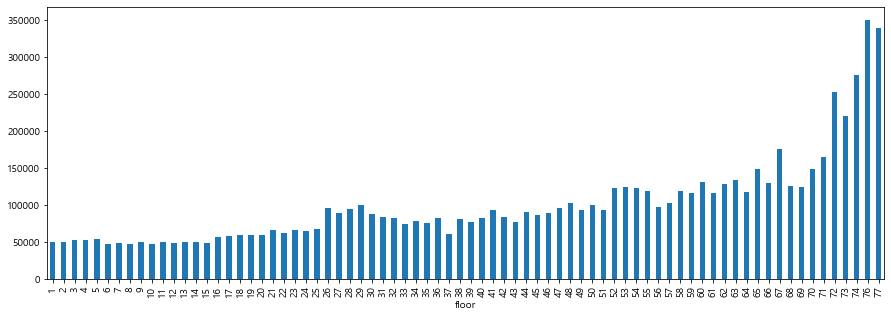

In [94]:
# floor 별 가격 평균 가격 bar plot
df.groupby('floor')['Y'].mean().plot(kind = 'bar')
plt.show()
# 나이브하게 1~25 / 26 ~ 51 / 52 ~ 71 / 71 ~ 로 나눌 수 있어 보임.

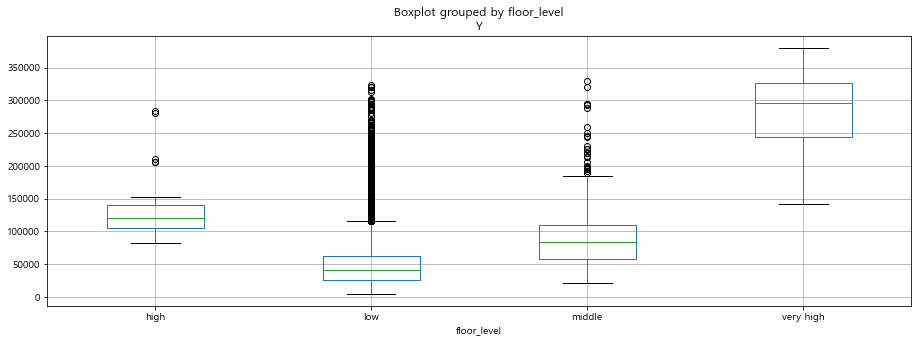

In [98]:
# floor 별 가격 박스 플랏
df.boxplot(column= 'Y', by = 'floor_level')
plt.show()
# 4개의 level의 가격 분포의 중심은 명확히 차이가 나 보인다.
# low level의 outlier가 매우 많다. -> 낮아도 비싼 아파트는 비싼 가격임을 알 수 있다.
# -> 이는 지역적 특성을 갖을 확율이 높아 보인다.
# 높은 층을 가진 아파트는 비싼 아파트일 것이다.

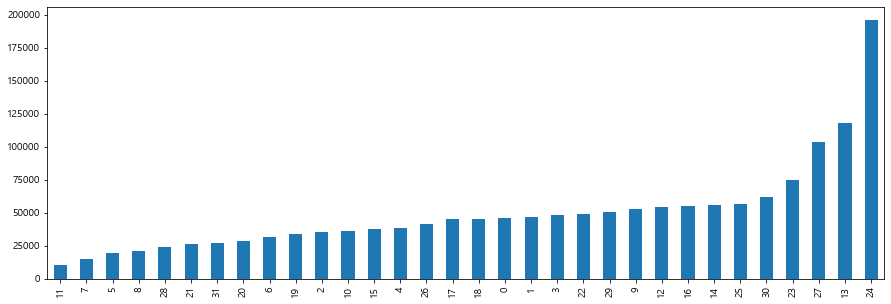

In [109]:
# 구별 평균 시세 - 평균 : 49,633
mean_price_per_gu['Y'].plot(kind = 'bar', c)
plt.show()
# 27, 13, 24 번 구의 가격이 다른 구에 비해 높음을 알수있다.
# 평균보다 낮은 구, 평균보다 높은 구, outlier 구 세가지고 범주화 가능해 보인다.

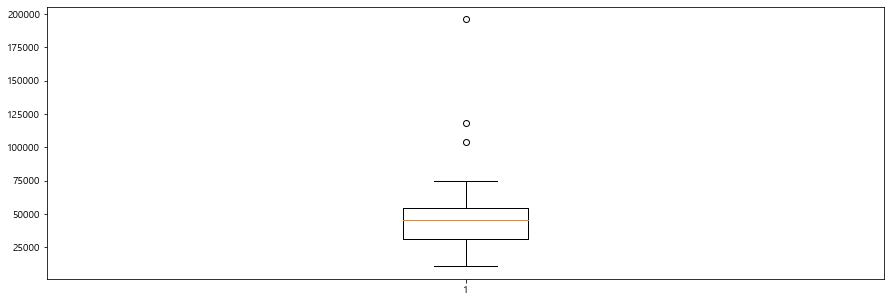

In [113]:
# 구별 평균의 박스 플랏 
plt.boxplot(mean_price_per_gu['Y'])
plt.show()
#매우 높은 27,13,24는 outlier로 따로 범주화 한다.

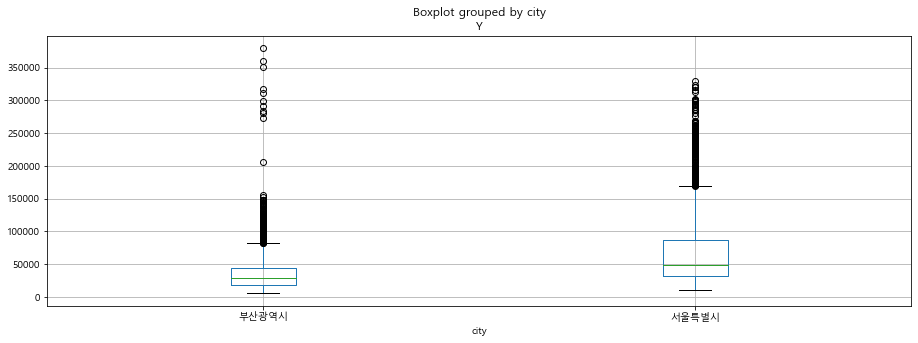

In [373]:
# 서울부산 박스플롯
Train.boxplot(column='Y', by = 'city')
plt.show()

In [194]:
Train_Y.describe()

count     27012.000000
mean      53250.530542
std       39218.600719
min        6500.000000
25%       26400.000000
50%       42000.000000
75%       65000.000000
max      379840.000000
Name: Y, dtype: float64